In [1]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

from random import randint

## Load Network

터미널 상 현재 디렉토리에서 아래 코드를 실행하면 ```.prototxt```파일과 ```.caffemodel```파일을 볼 수 있다.
> cd pose/coo  
ls

```.prototxt```파일은 뉴럴 네트워크의 아키텍처를 정의하고,  
```.caffemodel```파일은 trained model의 weights들을 저장한다. 

이 두 파일을 사용해서, 메모리에 네트워크를 불러오자. 

In [2]:
protoFile = "pose/coco/pose_deploy_linevec.prototxt"
weightsFile = "pose/coco/pose_iter_440000.caffemodel"

nPoints = 18
# COCO Output Format
keypointsMapping = ['Nose', 'Neck', 'R-Sho', 'R-Elb', 'R-Wr', 'L-Sho', 
                    'L-Elb', 'L-Wr', 'R-Hip', 'R-Knee', 'R-Ank', 'L-Hip', 
                    'L-Knee', 'L-Ank', 'R-Eye', 'L-Eye', 'R-Ear', 'L-Ear']

POSE_PAIRS = [[1,2], [1,5], [2,3], [3,4], [5,6], [6,7],
              [1,8], [8,9], [9,10], [1,11], [11,12], [12,13],
              [1,0], [0,14], [14,16], [0,15], [15,17],
              [2,17], [5,16] ]

# index of pafs correspoding to the POSE_PAIRS
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], 
          [19,20], [21,22], [23,24], [25,26], [27,28], [29,30], 
          [47,48], [49,50], [53,54], [51,52], [55,56], 
          [37,38], [45,46]]

colors = [ [0,100,255], [0,100,255], [0,255,255], [0,100,255], [0,255,255], [0,100,255],
         [0,255,0], [255,200,100], [255,0,255], [0,255,0], [255,200,100], [255,0,255],
         [0,0,255], [255,0,0], [200,200,0], [255,0,0], [200,200,0], [0,0,0]]


```nPoints```는 각 모델의 output 수를 의미한다.
```COCO``` 데이터셋으로 학습한 모델의 경우 18개의 keypoints를 출력하기 때문에, ```nPoints```가 18이다.  

```keypointsMapping```은 18개의 keypoints가 각각 어디를 나타내는지 보여준다.
나중에 keypoint index를 지정해서 히트맵을 출력할텐데, i=0으로 지정하면 이미지 상 Nose joint를 찍어낼 것이고, i=6으로 지정하면 이미지 상 Left elbow joint를 찍어낼 것이다.

```POSE_PAIRS```는 실제 human anatomy 상 연결 된 조인트들이다. 이를 미리 지정해주면 나중에 joint들끼리 연결지을 때 굳이 모든 관절들 간의 association을 고려하지 않아도 되어서 parsing할 때 좋다.

위의 ```POSE_PAIRS``` 각각에 해당하는 Partial Affinity Fields(PAF)가 나중에 출력되었을 때, 그 PAF의 output상 index가 ```mapIdx```이다. 예를 들어, ```POSE_PAIRS```중 첫번째인 목-오른쪽어깨(1,2)의 경우, 그 PAF의 index는 (31,32)인 것이다.

#### Let us load an image with multiple people and check what the model sees

아래 사진을 예시로 활용해보자.
<p align="center"><img src="mipal.jpg" width="300"></p>

In [3]:
#image1 = cv2.imread("group.jpg")
image1 = cv2.imread("mipal.jpg")
print(image1.shape)

frameWidth = image1.shape[1]
frameHeight = image1.shape[0]

(667, 1000, 3)


#### Load the network and pass the image through the network

이미지를 OpenCV 포맷에서 Caffe blob 포맷으로 변환시켜야 한다.

이를 위해 [blobFromImage](https://docs.opencv.org/3.4/d6/d0f/group__dnn.html#ga29f34df9376379a603acd8df581ac8d7)함수를 사용할 수 있다.  
pixel들을 (0,1) 범위로 normalize시키고, 이미지 dimension 지정해주고, mean value인 (0,0,0)을 subtract해주자.

변환된 이미지를 네트워크에 포워드시키자. Forward pass를 위해 ```net.forward()```함수를 사용한다.

In [4]:
t = time.time()

# Read the network into memory
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

# Fix the input Height and get the width according to the Aspect Ratio
inHeight = 368
inWidth = int((inHeight/frameHeight)*frameWidth)

inpBlob = cv2.dnn.blobFromImage(image1, 1.0 / 255, (inWidth, inHeight),
                          (0, 0, 0), swapRB=False, crop=False)

net.setInput(inpBlob)

output = net.forward()
H = output.shape[2]
W = output.shape[3]
print(output.shape)

print("Time Taken = {}".format(time.time() - t))

(1, 57, 46, 69)
Time Taken = 8.097118854522705


### Output format

```print(output.shape)```시행 결과, 4D matrix가 출력됨을 볼 수 있다.

첫번째 dimension ```1```은 이미지 ID를 나타낸다.

두번째 dimension ```44```은 keypoint 인덱스를 나타내는 부분이다. 
일전에 모델의 출력물이 Confidence Map과 Part Affinity Map라고 설명했었다. 실제로는 이것들이 모두 concatenated된 형태로 출력된다. 

우리가 예시로 보고자 하는 MPI모델의 경우 15(keypoints) + 1(background) + 14 * 2(pose pairs) = ```44```짜리 dimension을 갖는다.
참고로 COCO 모델의 경우, 18(keypoint) + 1(background) + 19 * 2(pose pairs) = ```57```짜리 dimension을 갖는다.

세번째 dimension ```46```은 Output map의 height를 나타낸다.
네번째 dimension ```46```은 Output map의 width를 나타낸다.

#### Slice a probability map ( for e.g Nose ) from the output for a specific keypoint and plot the heatmap ( after resizing ) on the image itself

특정 keypoint에 대해 Confidence map을 그려보자. 참고로 아래 코드에서는 첫번째 keypoint(i=0)인 Nose에 대한 Confidence map을 출력하고 있다.

OpenCV에서 color space 변환을 위해 ```cv2.cvtColor()```함수를 사용할 수 있다. OpenCV에서는 원래 BGR이기 때문에, 이를 RGB로 변환해주기 위해 ```cv2.COLOR_BGR2RGB```를 파라미터로 넣는다.

cf. BGR이기 때문에, 만약 변환하지 않은 상태로 ```plt.imshow(image1)```를 바로 시행하면 공포영화(?)스러운 비주얼을 볼 수 있다.

(-0.5, 999.5, 666.5, -0.5)

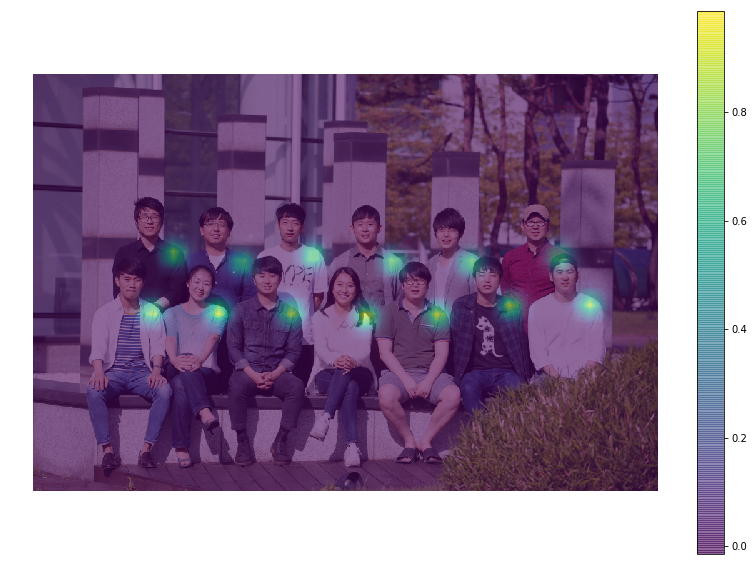

In [5]:
i = 5
probMap = output[0, i, :, :]
probMap = cv2.resize(probMap, (frameWidth, frameHeight))

plt.figure(figsize=[14,10])
plt.imshow(cv2.cvtColor(image1, cv2.COLOR_BGR2RGB))
plt.imshow(probMap, alpha=0.6)
plt.colorbar()
plt.axis("off")

In [6]:
probMap

array([[0.00017622, 0.00017622, 0.00017622, ..., 0.00412925, 0.00412925,
        0.00412925],
       [0.00017622, 0.00017622, 0.00017622, ..., 0.00412925, 0.00412925,
        0.00412925],
       [0.00017622, 0.00017622, 0.00017622, ..., 0.00412925, 0.00412925,
        0.00412925],
       ...,
       [0.00033952, 0.00033952, 0.00033952, ..., 0.0004185 , 0.0004185 ,
        0.0004185 ],
       [0.00033952, 0.00033952, 0.00033952, ..., 0.0004185 , 0.0004185 ,
        0.0004185 ],
       [0.00033952, 0.00033952, 0.00033952, ..., 0.0004185 , 0.0004185 ,
        0.0004185 ]], dtype=float32)

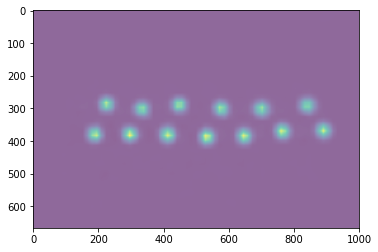

In [7]:
probMap.shape
plt.imshow(probMap, alpha=0.6)

## Detection of keypoints

각 keypoint에 대한 confidence map이 주어졌다. Single person의 pose estimation 문제의 경우 confidence map 상 maximum 포인트들 찾아서 이으면 되는데, Multi-people 문제에서는 그렇게 하면 안된다. (내 오른쪽 팔꿈치랑, 옆사람의 왼쪽 팔목이 연결되는 일이 생길 수 있음)

아래의 함수 ```getKeypoints```는 ```probMap```과 ```threshold```를 파라미터로 갖는다.   
```probMap```은 위에서 구한 confidence map을 의미한다.  
```threshold```는 [Non Maximum Suppression](https://ko.coursera.org/lecture/convolutional-neural-networks/non-max-suppression-dvrjH)을 위해 사용된다. 여기서는 Keypoint의 ```threshold```를 0.1로 설정했다. 

In [8]:
# Find the Keypoints using Non Maximum Suppression on the Confidence Map
def getKeypoints(probMap, threshold=0.1):
    
    mapSmooth = cv2.GaussianBlur(probMap,(3,3),0,0)
    mapMask = np.uint8(mapSmooth>threshold)
    keypoints = []
    
    #find the blobs
    _, contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    #for each blob find the maxima
    for cnt in contours:
        blobMask = np.zeros(mapMask.shape)
        blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)
        maskedProbMap = mapSmooth * blobMask
        _, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)
        keypoints.append(maxLoc + (probMap[maxLoc[1], maxLoc[0]],))

    return keypoints


위에서 ```mapSmooth```는 confidence map에 가우시안 필터링(3x3 kernel)을 적용한 것이다. ```mapMask```는 그 중에 값이 threshold 이상인 지점들만 걸러낸 것이다. 

정확한 keypoint location을 찾기 위해, 각 blob의 maxima 포인트를 찾아야한다.

#### keypoint에 해당하는 contour region들을 찾아낸다.
```_, contours, _ = cv2.findContours(mapMask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)```

#### contour region에 마스크를 씌우고, fillConvexPoly를 사용해서 나머지 부분은 블랙아웃 시킨다.
```blobMask = np.zeros(mapMask.shape)```
```blobMask = cv2.fillConvexPoly(blobMask, cnt, 1)```

#### 위에서 얻어낸 mapSmooth에 마스크를 씌워준다.
```maskedProbMap = mapSmooth * blobMask```

#### contour region 상 local maxima를 구한다.
```_, maxVal, _, maxLoc = cv2.minMaxLoc(maskedProbMap)```  
```maxLoc```는 해당 keypoint의 (x,y)좌표이다. 

In [10]:
detected_keypoints = []
keypoints_list = np.zeros((0,3))
keypoint_id = 0
threshold = 0.1

for part in range(nPoints):
    probMap = output[0,part,:,:]
    probMap = cv2.resize(probMap, (image1.shape[1], image1.shape[0]))
#     plt.figure()
#     plt.imshow(255*np.uint8(probMap>threshold))
    keypoints = getKeypoints(probMap, threshold)
    print("Keypoints - {} : {}".format(keypointsMapping[part], keypoints))
    keypoints_with_id = []
    for i in range(len(keypoints)):
        keypoints_with_id.append(keypoints[i] + (keypoint_id,))
        keypoints_list = np.vstack([keypoints_list, keypoints[i]])
        keypoint_id += 1

    detected_keypoints.append(keypoints_with_id)


Keypoints - Nose : [(499, 341, 0.8984122), (614, 340, 0.8792805), (268, 340, 0.8920978), (165, 339, 0.7674963), (370, 326, 0.8631425), (730, 326, 0.83053005), (848, 326, 0.8972293), (659, 254, 0.94938135), (296, 253, 0.8648463), (529, 252, 0.8598334), (412, 240, 0.8531048), (804, 239, 0.911071), (181, 238, 0.83122313)]
Keypoints - Neck : [(499, 384, 0.97208196), (602, 384, 0.8089693), (254, 383, 0.8246511), (152, 383, 0.91385067), (369, 383, 0.9109237), (731, 369, 0.8646195), (848, 369, 0.91596013), (672, 297, 0.76540184), (529, 297, 0.8262267), (296, 297, 0.7466469), (804, 296, 0.8647907), (412, 295, 0.794431), (181, 283, 0.84839743)]
Keypoints - R-Sho : [(457, 384, 0.7872177), (121, 383, 0.7461983), (572, 383, 0.8340755), (224, 384, 0.95856214), (339, 383, 0.72666645), (805, 370, 0.81723887), (688, 369, 0.89001626), (631, 298, 0.71526015), (485, 297, 0.7659008), (252, 297, 0.7467075), (761, 296, 0.8238981), (370, 296, 0.66484153), (150, 283, 0.77076346)]
Keypoints - R-Elb : [(558, 44

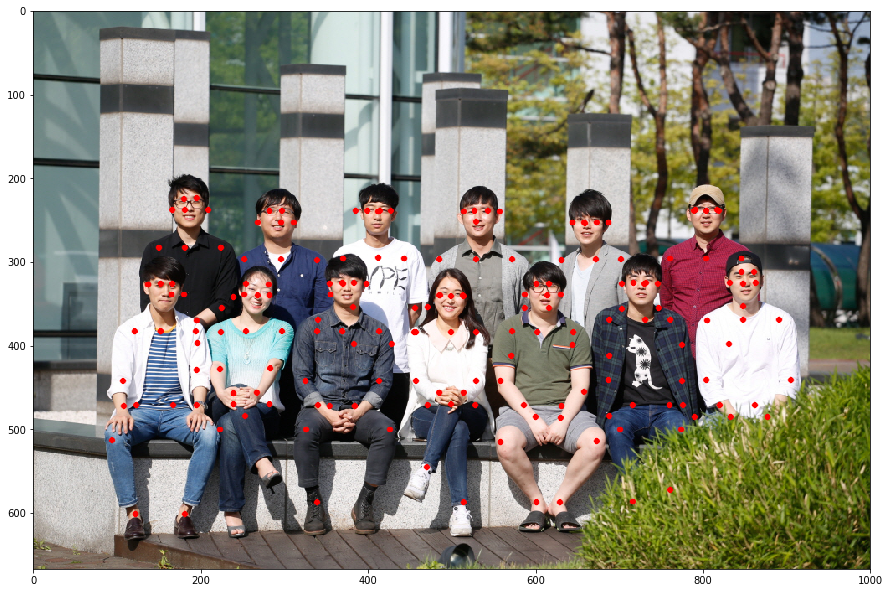

In [11]:
frameClone = image1.copy()
for i in range(nPoints):
    for j in range(len(detected_keypoints[i])):
        cv2.circle(frameClone, detected_keypoints[i][j][0:2], 3, [0,0,255], -1, cv2.LINE_AA)
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])

## Finding valid joint-pairs

![](./pose-estimation-paf-equation.png)

위 공식에서, L은 Partial Affinity Fields(PAF)를 의미한다.

```d``` 두 조인트j1과 j2를 연결하는 벡터 

```p``` 두 조인트 j1과 j2의 interpolated point

아래의 ```getValidPairs```함수를 뜯어보자. 

```for k in range(len(mapIdx)):```
참고로 맨 위에서 ```mapIdx```는 각 ```POSE_PAIRS```에 해당하는 Partial Affinity Fields(PAF)의 인덱스라고 설명했다. 즉 모든 ```POSE_PAIR```에 대하여 아래 과정을 시행한다.

```pafA```, ```pafB``` : 각 POSE_PAIR의 양쪽 조인트 각각의 PAF
```candA```, ```candB``` : 각 POSE_PAIR의 양쪽 조인트 각각의 candidates
```nA```, ```nB``` : 각 POSE_PAIR의 양쪽 조인트 각각의 후보들의 개수 (잘 예측되었을 경우 사람 수와 일치하겠지)

In [12]:
def getValidPairs(output):
    valid_pairs = []
    invalid_pairs = []
    n_interp_samples = 10
    paf_score_th = 0.1
    conf_th = 0.7
    # 모든 POSE_PAIR에 대해
    for k in range(len(mapIdx)):
        # limb의 한쪽 조인트 A, 다른쪽 조인트B 각각에 대한 paf
        pafA = output[0, mapIdx[k][0], :, :]
        pafB = output[0, mapIdx[k][1], :, :]
        pafA = cv2.resize(pafA, (frameWidth, frameHeight))
        pafB = cv2.resize(pafB, (frameWidth, frameHeight))

        # limb의 양쪽 keypoint 후보들
        candA = detected_keypoints[POSE_PAIRS[k][0]]
        candB = detected_keypoints[POSE_PAIRS[k][1]]
        nA = len(candA)
        nB = len(candB)

        # joint keypoint가 detect된 경우에 한해
        if( nA != 0 and nB != 0):
            valid_pair = np.zeros((0,3))
            # 조인트들 사이의 모든 interpolated points 집합에 대해 PAF를 계산한다
            for i in range(nA):
                max_j=-1
                maxScore = -1
                found = 0
                for j in range(nB):         
                    # 두 joint 사이의 distance vector(d_ij)계산
                    d_ij = np.subtract(candB[j][:2], candA[i][:2])
                    norm = np.linalg.norm(d_ij)
                    # distance vector(d_ij)를 normalize
                    if norm:
                        d_ij = d_ij / norm
                    else:
                        continue
                    # p(u)
                    interp_coord = list(zip(np.linspace(candA[i][0], candB[j][0], num=n_interp_samples),
                                            np.linspace(candA[i][1], candB[j][1], num=n_interp_samples)))
                    # L(p(u))
                    paf_interp = []
                    for k in range(len(interp_coord)):
                        paf_interp.append([pafA[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))],
                                           pafB[int(round(interp_coord[k][1])), int(round(interp_coord[k][0]))] ]) 
                    # E
                    paf_scores = np.dot(paf_interp, d_ij)
                    avg_paf_score = sum(paf_scores)/len(paf_scores)

                    # Connection이 valid한지 체크하기 위해 threshold로 걸러낸다  
                    if ( len(np.where(paf_scores > paf_score_th)[0]) / n_interp_samples ) > conf_th :
                        if avg_paf_score > maxScore:
                            max_j = j
                            maxScore = avg_paf_score
                            found = 1
                # Valid한 connection들 저장
                if found:            
                    valid_pair = np.append(valid_pair, [[candA[i][3], candB[max_j][3], maxScore]], axis=0)

            # valid_pair과 valid_pairs 다름 주의 - valid_pairs는 global variable
            valid_pairs.append(valid_pair)
            
        # Keypoint가 detect되지 않았을 경우
        else: 
            print("No Connection : k = {}".format(k))
            invalid_pairs.append(k)
            valid_pairs.append([])
    print(valid_pairs)
    return valid_pairs, invalid_pairs

위의 ```getValidPairs```함수는 앞서 detect된 joint keypoints에 대해, valid pair를 걸러주는 역할을 한다.  

#### 1) 조인트들 사이의 interpolated points 집합 추출
```interp_coord```가 추출된 interpolated points 집합이다.

#### 2) (interpolated points들의 PAF)와, (d_ij의 방향)이 비슷할수록 높은 paf_score를 매긴다.  
```paf_interp```가 추출된 interpolated points의 paf값이고, 이를 )```d_ij```와 내적한다.  
```paf_scores = np.dot(paf_interp, d_ij)```

####  3) paf_scores가 threshold값 이상이며, interpolated points 중 valid한 points의 비율 또한 threshold값 이상일 때, valid pair라고 할 수 있다.
```if ( len(np.where(paf_scores > paf_score_th)[0]) / n_interp_samples ) > conf_th :```

In [13]:
valid_pairs, invalid_pairs = getValidPairs(output)

[array([[13.        , 26.        ,  0.96626785],
       [14.        , 28.        ,  1.05275629],
       [15.        , 29.        ,  1.08435918],
       [16.        , 27.        ,  0.93839005],
       [17.        , 30.        ,  1.01132882],
       [18.        , 32.        ,  0.98722521],
       [19.        , 31.        ,  0.95119402],
       [20.        , 33.        ,  0.85194545],
       [21.        , 34.        ,  0.82532719],
       [22.        , 35.        ,  0.82106912],
       [23.        , 36.        ,  1.00835857],
       [24.        , 37.        ,  0.89599903],
       [25.        , 38.        ,  0.90970672]]), array([[13.        , 60.        ,  0.91709598],
       [14.        , 61.        ,  1.02873111],
       [15.        , 62.        ,  0.99025637],
       [16.        , 63.        ,  0.95023484],
       [17.        , 64.        ,  0.97924268],
       [18.        , 65.        ,  0.98648546],
       [19.        , 66.        ,  1.01876435],
       [20.        , 68.        ,  0.

# Assemble Person-wise Keypoints

이제 Valid한 keypoint pair들을, 사람 별로 매칭시키자.

In [15]:
# for each detected valid pair, it assigns the joint(s) to a person
# It finds the person and index at which the joint should be added. This can be done since we have an id for each joint
def getPersonwiseKeypoints(valid_pairs, invalid_pairs): 
    #각 사람의 keypoints를 저장하기 위한 empty list 생성
    personwiseKeypoints = -1 * np.ones((0, 19))

    for k in range(len(mapIdx)):
        if k not in invalid_pairs:
            partAs = valid_pairs[k][:,0]
            partBs = valid_pairs[k][:,1]
            indexA, indexB = np.array(POSE_PAIRS[k])
            #valid_pair 각각에 대해, partA가 personwiseKeypoints에 있는지 확인
            for i in range(len(valid_pairs[k])): 
                found = 0
                person_idx = -1
                for j in range(len(personwiseKeypoints)):
                    if personwiseKeypoints[j][indexA] == partAs[i]:
                        person_idx = j
                        found = 1
                        break
                # 만약 partA가 있다면, partB도 personwiseKeypoints에 추가
                if found:
                    personwiseKeypoints[person_idx][indexB] = partBs[i]
                    personwiseKeypoints[person_idx][-1] += keypoints_list[partBs[i].astype(int), 2] + valid_pairs[k][i][2]

                # 만댝 partA가 모든 list에 없다면, list에 없는 새로운 사람의 part라는 뜻
                elif not found and k < 17:
                    # partA-partB 전체를 한 row로 생성해서 추가
                    row = -1 * np.ones(19)
                    row[indexA] = partAs[i]
                    row[indexB] = partBs[i]
                    # 각 keypoint의 keypoint_scores와 paf_score도 추가
                    row[-1] = sum(keypoints_list[valid_pairs[k][i,:2].astype(int), 2]) + valid_pairs[k][i][2]
                    personwiseKeypoints = np.vstack([personwiseKeypoints, row])
    return personwiseKeypoints

In [16]:
personwiseKeypoints = getPersonwiseKeypoints(valid_pairs, invalid_pairs)

# Results

각 사람에 대해 skeleton을 그려보자

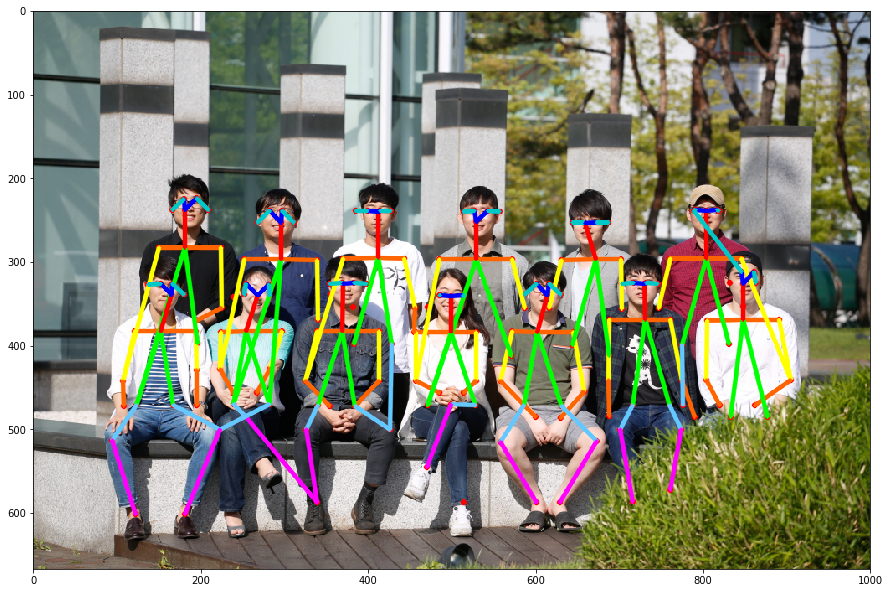

In [17]:
for i in range(17):
    for n in range(len(personwiseKeypoints)):
        index = personwiseKeypoints[n][np.array(POSE_PAIRS[i])]
        if -1 in index:
            continue
        B = np.int32(keypoints_list[index.astype(int), 0])
        A = np.int32(keypoints_list[index.astype(int), 1])
        cv2.line(frameClone, (B[0], A[0]), (B[1], A[1]), colors[i], 3, cv2.LINE_AA)
        
plt.figure(figsize=[15,15])
plt.imshow(frameClone[:,:,[2,1,0]])